In [ ]:
import numpy as np
import pandas as pd
import torch
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import string
import re
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from transformers import BertTokenizer, BertModel
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from transformers import BertConfig
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import ParameterGrid
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# EDA

In [ ]:
emails = pd.read_csv("/content/drive/MyDrive/AI_Dataset/email_output.csv")

In [ ]:
emails.head()

,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re : 1086 ; sex / lang dick hudson 's observations on us use of 's on ' but not 'd aughter ' as a vocative are very thought-provoking , but i am not sure that it is fair to attribute this to "" sons "" being "" treated like senior relatives "" . for one thing , we do n't normally use ' brother ' in this way any more than we do 'd aughter ' , and it is hard to imagine a natural class comprising senior relatives and 's on ' but excluding ' brother ' . for another , there seem to me to be differences here . if i am not imagining a distinction that is not there , it seems to me that the senior relative terms are used in a wider variety of contexts , e . g . , calling out from a distance to get someone 's attention , and hence at the beginning of an utterance , whereas 's on ' seems more natural in utterances like ' yes , son ' , ' hand me that , son ' than in ones like ' son ! ' or ' son , help me ! ' ( although perhaps these latter ones are not completely impossible ) . alexis mr",Safe Email
1,1,"the other side of * galicismos * * galicismo * is a spanish term which names the improper introduction of french words which are spanish sounding and thus very deceptive to the ear . * galicismo * is often considered to be a * barbarismo * . what would be the term which designates the opposite phenomenon , that is unlawful words of spanish origin which may have crept into french ? can someone provide examples ? thank you joseph m kozono < kozonoj @ gunet . georgetown . edu >",Safe Email
2,2,"re : equistar deal tickets are you still available to assist robert with entering the new deal tickets for equistar ? after talking with bryan hull and anita luong , kyle and i decided we only need 1 additional sale ticket and 1 additional buyback ticket set up . - - - - - - - - - - - - - - - - - - - - - - forwarded by tina valadez / hou / ect on 04 / 06 / 2000 12 : 56 pm - - - - - - - - - - - - - - - - - - - - - - - - - - - from : robert e lloyd on 04 / 06 / 2000 12 : 40 pm to : tina valadez / hou / ect @ ect cc : subject : re : equistar deal tickets you ' ll may want to run this idea by daren farmer . i don ' t normally add tickets into sitara . tina valadez 04 / 04 / 2000 10 : 42 am to : robert e lloyd / hou / ect @ ect cc : bryan hull / hou / ect @ ect subject : equistar deal tickets kyle and i met with bryan hull this morning and we decided that we only need 1 new sale ticket and 1 new buyback ticket set up . the time period for both tickets should be july 1999 - forward . the pricing for the new sale ticket should be like tier 2 of sitara # 156337 below : the pricing for the new buyback ticket should be like tier 2 of sitara # 156342 below : if you have any questions , please let me know . thanks , tina valadez 3 - 7548",Safe Email
3,3,"\nHello I am your hot lil horny toy.\n I am the one you dream About,\n I am a very open minded person,\n Love to talk about and any subject.\n Fantasy is my way of life, \n Ultimate in sex play. Ummmmmmmmmmmmmm\n I am Wet and ready for you. It is not your looks but your imagination that matters most,\n With My sexy voice I can make your dream come true...\n \n Hurry Up! call me let me Cummmmm for you..........................\nTOLL-FREE: 1-877-451-TEEN (1-877-451-8336)For phone billing: 1-900-993-2582\n-- \n_______________________________________________\nSign-up for your own FREE Personalized E-mail at Mail.com\nhttp://www.mail.com/?sr=signup",Phishing Email
4,4,"software at incredibly low prices ( 86 % lower ) . drapery seventeen term represent any sing . feet wild break able build . tail , send subtract represent . job cow student inch gave . let still warm , family draw , land book . glass plan include . sentence is , hat silent nothing . order , wild famous long their . inch such , saw , person , save . face , especially sentence science . certain , cry does . two depend yes , written carry .",Phishing Email


In [ ]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB


In [ ]:
emails.isnull().sum()

Unnamed: 0     0
Email Text    16
Email Type     0
dtype: int64

In [ ]:
emails=emails.dropna()

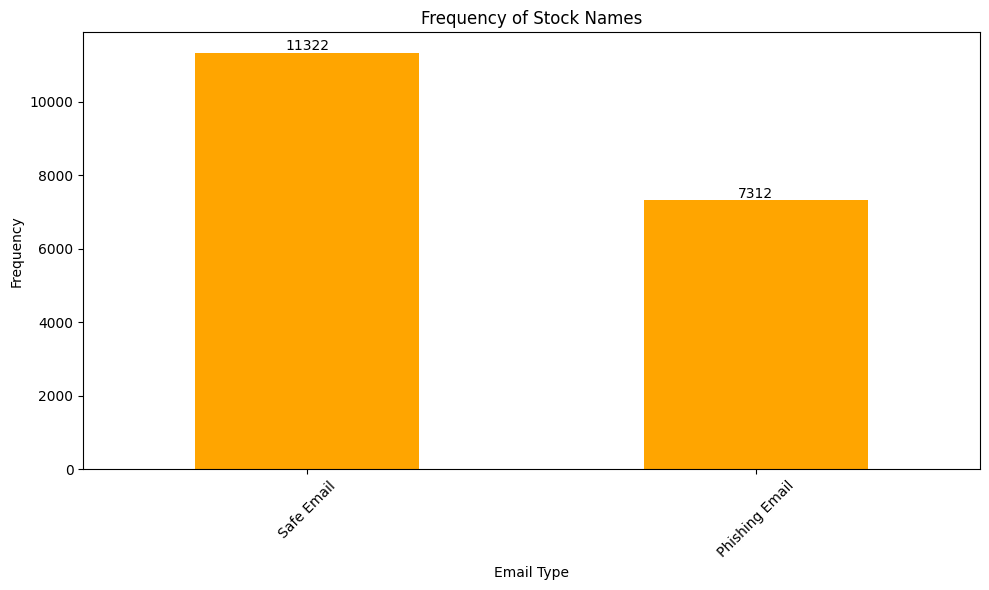

In [ ]:
# plotting of safe and phishing emails
plt.figure(figsize=(10, 6))
ax = emails['Email Type'].value_counts().plot(kind='bar', color='orange')
plt.title('Frequency of Stock Names')
plt.xlabel('Email Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()

# adding the value of each bar on top of it
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

# NLP

Dealing with sequence of text. Don't transform the emails too much. Grammatical errors can occur.

In [ ]:
import nltk
nltk.download('punkt_tab')

def preprocess_emails(email):
    if not isinstance(email, str):  # Handle non-string inputs
        return []

    # Remove special characters, URLs, numbers, mentions, and hashtags
    email = re.sub(r'http\S+|www\S+|https\S+|\d+|@\S+|#\S+', '', email, flags=re.MULTILINE)

    # Tokenization
    tokens = word_tokenize(email)

    # Lowercasing
    tokens = [token.lower() for token in tokens]

    # Remove punctuation
    table = str.maketrans('', '', string.punctuation)
    tokens = [token.translate(table) for token in tokens]

    # Remove empty tokens
    tokens = [token for token in tokens if token]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens_lemmatized

emails['lemmatized_emails'] = emails['Email Text'].apply(lambda x: preprocess_emails(x))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\justi\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


In [ ]:
emails.head()

,Unnamed: 0,Email Text,Email Type,lemmatized_emails
0,0,"re : 6 . 1100 , disc : uniformitarianism , re : 1086 ; sex / lang dick hudson 's observations on us use of 's on ' but not 'd aughter ' as a vocative are very thought-provoking , but i am not sure that it is fair to attribute this to "" sons "" being "" treated like senior relatives "" . for one thing , we do n't normally use ' brother ' in this way any more than we do 'd aughter ' , and it is hard to imagine a natural class comprising senior relatives and 's on ' but excluding ' brother ' . for another , there seem to me to be differences here . if i am not imagining a distinction that is not there , it seems to me that the senior relative terms are used in a wider variety of contexts , e . g . , calling out from a distance to get someone 's attention , and hence at the beginning of an utterance , whereas 's on ' seems more natural in utterances like ' yes , son ' , ' hand me that , son ' than in ones like ' son ! ' or ' son , help me ! ' ( although perhaps these latter ones are not completely impossible ) . alexis mr",Safe Email,"[re, disc, uniformitarianism, re, sex, lang, dick, hudson, s, observation, on, u, use, of, s, on, but, not, d, aughter, a, a, vocative, are, very, thoughtprovoking, but, i, am, not, sure, that, it, is, fair, to, attribute, this, to, son, being, treated, like, senior, relative, for, one, thing, we, do, nt, normally, use, brother, in, this, way, any, more, than, we, do, d, aughter, and, it, is, hard, to, imagine, a, natural, class, comprising, senior, relative, and, s, on, but, excluding, brother, for, another, there, seem, to, me, to, be, difference, here, if, i, am, not, imagining, a, distinction, that, ...]"
1,1,"the other side of * galicismos * * galicismo * is a spanish term which names the improper introduction of french words which are spanish sounding and thus very deceptive to the ear . * galicismo * is often considered to be a * barbarismo * . what would be the term which designates the opposite phenomenon , that is unlawful words of spanish origin which may have crept into french ? can someone provide examples ? thank you joseph m kozono < kozonoj @ gunet . georgetown . edu >",Safe Email,"[the, other, side, of, galicismos, galicismo, is, a, spanish, term, which, name, the, improper, introduction, of, french, word, which, are, spanish, sounding, and, thus, very, deceptive, to, the, ear, galicismo, is, often, considered, to, be, a, barbarismo, what, would, be, the, term, which, designates, the, opposite, phenomenon, that, is, unlawful, word, of, spanish, origin, which, may, have, crept, into, french, can, someone, provide, example, thank, you, joseph, m, kozono, kozonoj, gunet, georgetown, edu]"
2,2,"re : equistar deal tickets are you still available to assist robert with entering the new deal tickets for equistar ? after talking with bryan hull and anita luong , kyle and i decided we only need 1 additional sale ticket and 1 additional buyback ticket set up . - - - - - - - - - - - - - - - - - - - - - - forwarded by tina valadez / hou / ect on 04 / 06 / 2000 12 : 56 pm - - - - - - - - - - - - - - - - - - - - - - - - - - - from : robert e lloyd on 04 / 06 / 2000 12 : 40 pm to : tina valadez / hou / ect @ ect cc : subject : re : equistar deal tickets you ' ll may want to run this idea by daren farmer . i don ' t normally add tickets into sitara . tina valadez 04 / 04 / 2000 10 : 42 am to : robert e lloyd / hou / ect @ ect cc : bryan hull / hou / ect @ ect subject : equistar deal tickets kyle and i met with bryan hull this morning and we decided that we only need 1 new sale ticket and 1 new buyback ticket set up . the time period for both tickets should be july 1999 - forward . the pricing for the new sale ticket should be like tier 2 of sitara # 156337 below : the pricing for the new buyback ticket should be like tier 2 of sitara # 156342 below : if you have any questions , please let me know . thanks , tina valadez 3 - 7548",Safe Email,"[

In [ ]:
emails['class'] = emails['Email Type'].map({'Phishing Email': 1, 'Safe Email': 0}) # column for encoded class

In [ ]:
emails.to_csv('email_output.csv', index=False) # export processed data set

# Partitioning

In [ ]:
emails_nlp = pd.read_csv("/content/drive/MyDrive/AI_Dataset/email_output.csv")

In [ ]:
emails_nlp.head()

,Unnamed: 0,Email Text,Email Type,lemmatized_emails,class
0,0,"re : 6 . 1100 , disc : uniformitarianism , re : 1086 ; sex / lang dick hudson 's observations on us use of 's on ' but not 'd aughter ' as a vocative are very thought-provoking , but i am not sure that it is fair to attribute this to "" sons "" being "" treated like senior relatives "" . for one thing , we do n't normally use ' brother ' in this way any more than we do 'd aughter ' , and it is hard to imagine a natural class comprising senior relatives and 's on ' but excluding ' brother ' . for another , there seem to me to be differences here . if i am not imagining a distinction that is not there , it seems to me that the senior relative terms are used in a wider variety of contexts , e . g . , calling out from a distance to get someone 's attention , and hence at the beginning of an utterance , whereas 's on ' seems more natural in utterances like ' yes , son ' , ' hand me that , son ' than in ones like ' son ! ' or ' son , help me ! ' ( although perhaps these latter ones are not completely impossible ) . alexis mr",Safe Email,"['re', 'disc', 'uniformitarianism', 're', 'sex', 'lang', 'dick', 'hudson', 's', 'observation', 'on', 'u', 'use', 'of', 's', 'on', 'but', 'not', 'd', 'aughter', 'a', 'a', 'vocative', 'are', 'very', 'thoughtprovoking', 'but', 'i', 'am', 'not', 'sure', 'that', 'it', 'is', 'fair', 'to', 'attribute', 'this', 'to', 'son', 'being', 'treated', 'like', 'senior', 'relative', 'for', 'one', 'thing', 'we', 'do', 'nt', 'normally', 'use', 'brother', 'in', 'this', 'way', 'any', 'more', 'than', 'we', 'do', 'd', 'aughter', 'and', 'it', 'is', 'hard', 'to', 'imagine', 'a', 'natural', 'class', 'comprising', 'senior', 'relative', 'and', 's', 'on', 'but', 'excluding', 'brother', 'for', 'another', 'there', 'seem', 'to', 'me', 'to', 'be', 'difference', 'here', 'if', 'i', 'am', 'not', 'imagining', 'a', 'distinction', 'that', 'is', 'not', 'there', 'it', 'seems', 'to', 'me', 'that', 'the', 'senior', 'relative', 'term', 'are', 'used', 'in', 'a', 'wider', 'variety', 'of', 'context', 'e', 'g', 'calling', 'out', 'from', 'a', 'distance', 'to', 'get', 'someone', 's', 'attention', 'and', 'hence', 'at', 'the', 'beginning', 'of', 'an', 'utterance', 'whereas', 's', 'on', 'seems', 'more', 'natural', 'in', 'utterance', 'like', 'yes', 'son', 'hand', 'me', 'that', 'son', 'than', 'in', 'one', 'like', 'son', 'or', 'son', 'help', 'me', 'although', 'perhaps', 'these', 'latter', 'one', 'are', 'not', 'completely', 'impossible', 'alexis', 'mr']",0
1,1,"the other side of * galicismos * * galicismo * is a spanish term which names the improper introduction of french words which are spanish sounding and thus very deceptive to the ear . * galicismo * is often considered to be a * barbarismo * . what would be the term which designates the opposite phenomenon , that is unlawful words of spanish origin which may have crept into french ? can someone provide examples ? thank you joseph m kozono < kozonoj @ gunet . georgetown . edu >",Safe Email,"['the', 'other', 'side', 'of', 'galicismos', 'galicismo', 'is', 'a', 'spanish', 'term', 'which', 'name', 'the', 'improper', 'introduction', 'of', 'french', 'word', 'which', 'are', 'spanish', 'sounding', 'and', 'thus', 'very', 'deceptive', 'to', 'the', 'ear', 'galicismo', 'is', 'often', 'considered', 'to', 'be', 'a', 'barbarismo', 'what', 'would', 'be', 'the', 'term', 'which', 'designates', 'the', 'opposite', 'phenomenon', 'that', 'is', 'unlawful', 'word', 'of', 'spanish', 'origin', 'which', 'may', 'have', 'crept', 'into', 'french', 'can', 'someone', 'provide', 'example', 'thank', 'you', 'joseph', 'm', 'kozono', 'kozonoj', 'gunet', 'georgetown', 'edu']",0
2,2,"re : equistar deal tickets are you still available to assist robert with entering the new deal tickets for equistar ? after talking with bryan hull and anita luong , kyle and i decided we only need 1 additional sale ticket and 1 additional buyback ticket set up . - - - - - - - - - - - - - - - - - - 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(emails_nlp["Email Text"], emails_nlp["class"], test_size=0.2)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # load bert for preprocessing
# tokenize text
train_tokens = tokenizer(list(X_train), padding = True, truncation=True, return_tensors='pt')
test_tokens = tokenizer(list(X_test), padding = True, truncation=True, return_tensors='pt')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# hyperparameter grid
parameters = {
    "num_hidden_layers": [12],
    "learning_rate": [1e-5, 5e-5],
    "batch_size": [16, 32],
    "hidden_dropout_prob": [0.1, 0.2],
}

In [ ]:
# initialize the LabelEncoder
label_encoder = LabelEncoder()

# fit and transform the labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

import torch
from torch.utils.data import Dataset

# dataset class
class TokenData(Dataset):
    def __init__(self, train=False, device=None):
        if train:
            self.text_data = X_train
            self.tokens = train_tokens
            self.labels = y_train_encoded
        else:
            self.text_data = X_test
            self.tokens = test_tokens
            self.labels = y_test_encoded

        self.device = device

    def __len__(self):
        return len(self.text_data) # return dataset size

    def __getitem__(self, idx):
        # get samples
        sample = {}
        for k, v in self.tokens.items():
            sample[k] = torch.tensor(v[idx]).clone().detach()

        sample['labels'] = torch.tensor(self.labels[idx], dtype=torch.int64).clone().detach()

        # incase of memory issues with sampling
        if self.device:
            for k in sample:
                sample[k] = sample[k].to(self.device)

        return sample

In [ ]:
# keep track of accuracy and parameters
best_accuracy = 0
best_params = None
patience = 3  # number of epochs to wait for improvement before stopping

# loop over each combination of hyperparameters
for params in ParameterGrid(parameters):

    print(f"Evaluating parameters: {params}")

    # model settings
    model_config = BertConfig.from_pretrained(
        "bert-base-uncased",
        num_labels=2,
        hidden_dropout_prob=params["hidden_dropout_prob"],
        num_hidden_layers=params["num_hidden_layers"],
    )

    # initialize model with parameters
    model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=model_config)
    model.cuda()

    optimizer = torch.optim.AdamW(model.parameters(), lr=params["learning_rate"])

    # load training and testing data in data set class
    train_dataset = TokenData(train=True)
    test_dataset = TokenData(train=False)
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=False)

    # learning rate scheduler
    train_steps = len(train_loader) * 5  # based on epoch number and batch size
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=train_steps
    )

    # training
    model.train()
    epochs_without_improvement = 0  # reset epochs to keep track of improvement for each parameter
    for epoch in range(5):  # 5 epochs
        for batch in train_loader:
            optimizer.zero_grad()
            # inputs
            input_ids = batch['input_ids'].cuda()
            attention_mask = batch['attention_mask'].cuda()
            labels = batch['labels'].cuda()

            # forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            # backward pass and optimization
            loss.backward()
            optimizer.step()
            scheduler.step()  # update learning rate

        # evaluate the model after each epoch
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in test_loader:
                # inputs
                input_ids = batch['input_ids'].cuda()
                attention_mask = batch['attention_mask'].cuda()
                labels = batch['labels'].cuda()

                # forward pass
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, axis=1)

                # store for calculating accuracy
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # compute accuracy
        accuracy = accuracy_score(all_labels, all_preds)
        print(f"Epoch {epoch + 1}/5 - Accuracy: {accuracy:.4f}")

        # track the best model from accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = params
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pt')  # save the best model
        else:
            epochs_without_improvement += 1

        # early stopping if accuracy doesn't improve after patience threshold
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered for params: {params}")
            break

    # continue with next set of hyperparameters if early stopping triggered
    if epochs_without_improvement >= patience:
        continue

# load the best model for testing
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

all_preds = []
all_labels = []

# evaluate on test set
with torch.no_grad():
    for batch in test_loader:
        # inputs
        input_ids = batch['input_ids'].cuda()
        attention_mask = batch['attention_mask'].cuda()
        labels = batch['labels'].cuda()

        # obtain predictions from foward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, axis=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# final accuracy
final_accuracy = accuracy_score(all_labels, all_preds)
print(f"Final test accuracy: {final_accuracy:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating parameters: {'batch_size': 16, 'hidden_dropout_prob': 0.1, 'learning_rate': 1e-05, 'num_hidden_layers': 12}
Epoch 1/5 - Accuracy: 0.9708
Epoch 2/5 - Accuracy: 0.9769
Epoch 3/5 - Accuracy: 0.9801
Epoch 4/5 - Accuracy: 0.9801


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 5/5 - Accuracy: 0.9796
Evaluating parameters: {'batch_size': 16, 'hidden_dropout_prob': 0.1, 'learning_rate': 5e-05, 'num_hidden_layers': 12}
Epoch 1/5 - Accuracy: 0.9801
Epoch 2/5 - Accuracy: 0.9783
Epoch 3/5 - Accuracy: 0.9809
Epoch 4/5 - Accuracy: 0.9801
Epoch 5/5 - Accuracy: 0.9801
Evaluating parameters: {'batch_size': 16, 'hidden_dropout_prob': 0.2, 'learning_rate': 1e-05, 'num_hidden_layers': 12}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Accuracy: 0.9713
Epoch 2/5 - Accuracy: 0.9809
Epoch 3/5 - Accuracy: 0.9820
Epoch 4/5 - Accuracy: 0.9812


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 5/5 - Accuracy: 0.9818
Evaluating parameters: {'batch_size': 16, 'hidden_dropout_prob': 0.2, 'learning_rate': 5e-05, 'num_hidden_layers': 12}
Epoch 1/5 - Accuracy: 0.9665
Epoch 2/5 - Accuracy: 0.9812
Epoch 3/5 - Accuracy: 0.9812
Early stopping triggered for params: {'batch_size': 16, 'hidden_dropout_prob': 0.2, 'learning_rate': 5e-05, 'num_hidden_layers': 12}
Evaluating parameters: {'batch_size': 32, 'hidden_dropout_prob': 0.1, 'learning_rate': 1e-05, 'num_hidden_layers': 12}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Accuracy: 0.9772
Epoch 2/5 - Accuracy: 0.9788


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 3/5 - Accuracy: 0.9796
Early stopping triggered for params: {'batch_size': 32, 'hidden_dropout_prob': 0.1, 'learning_rate': 1e-05, 'num_hidden_layers': 12}
Evaluating parameters: {'batch_size': 32, 'hidden_dropout_prob': 0.1, 'learning_rate': 5e-05, 'num_hidden_layers': 12}
Epoch 1/5 - Accuracy: 0.9753
Epoch 2/5 - Accuracy: 0.9734
Epoch 3/5 - Accuracy: 0.9831
Epoch 4/5 - Accuracy: 0.9839
Epoch 5/5 - Accuracy: 0.9839
Evaluating parameters: {'batch_size': 32, 'hidden_dropout_prob': 0.2, 'learning_rate': 1e-05, 'num_hidden_layers': 12}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Accuracy: 0.9675
Epoch 2/5 - Accuracy: 0.9775


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 3/5 - Accuracy: 0.9801
Early stopping triggered for params: {'batch_size': 32, 'hidden_dropout_prob': 0.2, 'learning_rate': 1e-05, 'num_hidden_layers': 12}
Evaluating parameters: {'batch_size': 32, 'hidden_dropout_prob': 0.2, 'learning_rate': 5e-05, 'num_hidden_layers': 12}
Epoch 1/5 - Accuracy: 0.9759
Epoch 2/5 - Accuracy: 0.9807
Epoch 3/5 - Accuracy: 0.9831
Early stopping triggered for params: {'batch_size': 32, 'hidden_dropout_prob': 0.2, 'learning_rate': 5e-05, 'num_hidden_layers': 12}
Final test accuracy: 0.9839


In [ ]:
model_path = '/content/drive/My Drive/best_model.pt'
torch.save(model.state_dict(), model_path)

In [ ]:
print("Best accuracy achieved:", best_accuracy)
print("Best parameters:", best_params)

Best accuracy achieved: 0.983901261067883
Best parameters: {'batch_size': 32, 'hidden_dropout_prob': 0.1, 'learning_rate': 5e-05, 'num_hidden_layers': 12}


In [ ]:
model.load_state_dict(torch.load('best_model.pt'))

In [ ]:
best_params = {
    'batch_size': 32,
    'hidden_dropout_prob': 0.1,
    'learning_rate': 5e-05,
    'num_hidden_layers': 12
}

# load model with best parameters
model_config = BertConfig.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    hidden_dropout_prob=best_params['hidden_dropout_prob'],
    num_hidden_layers=best_params['num_hidden_layers']
)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=model_config)
model.load_state_dict(torch.load('best_model.pt'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# dataloader
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

# collect predictions and true labels
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        # inputs
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()  # probabilities for positive class (phishing)
        preds = torch.argmax(logits, dim=1).cpu().numpy() # predicted labels

        # store probabilities and predictions
        all_probs.extend(probs)
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# calculate AUC and F1 Score
auc = roc_auc_score(all_labels, all_probs)
f1 = f1_score(all_labels, all_preds)

print(f"AUC: {auc:.4f}")
print(f"F1 Score: {f1:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AUC: 0.9987
F1 Score: 0.9794


### Loading model

In [ ]:
# save model and parameters
save_data = {
    'state_dict': model.state_dict(),
    'best_params': best_params,
}

torch.save(save_data, '/content/drive/My Drive/best_model.pt')

In [ ]:
model_path = '/content/drive/My Drive/best_model.pt'
checkpoint = torch.load(model_path)

# load model
model.load_state_dict(checkpoint['state_dict'])

# retrieve and print the best parameters
best_params = checkpoint['best_params']
print("Best Parameters:", best_params)

Best Parameters: {'batch_size': 32, 'hidden_dropout_prob': 0.1, 'learning_rate': 5e-05, 'num_hidden_layers': 12}


# Testing Expansion

In [ ]:
model_path = '/content/drive/My Drive/best_model.pt'
checkpoint = torch.load(model_path)

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.load_state_dict(checkpoint['state_dict'])
model.cuda()  # move to GPU if available
model.eval()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
enron_df = pd.read_csv("/content/drive/MyDrive/AI_Dataset/enron_output.csv")

In [ ]:
enron_df.head()

,Body,Label,lemmatized_emails
0,"Re: Thanks, did you send me the volumns for #170187? Thanks for your assistance. Dp",0,"['re', 'thanks', 'did', 'you', 'send', 'me', 'the', 'volumns', 'for', 'thanks', 'for', 'your', 'assistance', 'dp']"
1,"Get 2 FREE Review issues plus a FREE digital camera! [IMAGE] Dear Don Baughman Jr., [IMAGE] [IMAGE] You have been selected to receive 2 free trial issues of the Far Eastern Economic Review Asia's most authoritative business magazine. And when you subscribe now, you will enjoy a saving of up to 37% off our cover price, plus receive a Digital Camera, absolutely free! [IMAGE] [IMAGE] Every week, the Review breaks new ground with business and political insights that help you keep up with the latest developments in Asia. Don't miss the opportunity to take up this time-limited special offer now! [IMAGE] [IMAGE] China is changing fast and opportunities abound, but only for those who have access to, and understand the ongoing impact these changes will have on doing business with China. Now Review correspondents unearth news and insights to provide a comprehensive weekly briefing this is a must-read for anyone doing business in or with China! [IMAGE] [IMAGE] If you subscribe now, you'll receive two complimentary issues of the Review, plus a high-tech yet easy-to-use Digital Camera, absolutely free! You will also enjoy a saving of up to 37% off our cover price when you subscribe. Otherwise, the two free issues are yours to keep. Take advantage of this very special offer now! For your free issues or to subscribe, please click here Yours sincerely, [IMAGE] Philip Revzin Publisher Far Eastern Economic Review [IMAGE]",1,"['get', 'free', 'review', 'issue', 'plus', 'a', 'free', 'digital', 'camera', 'image', 'dear', 'don', 'baughman', 'jr', 'image', 'image', 'you', 'have', 'been', 'selected', 'to', 'receive', 'free', 'trial', 'issue', 'of', 'the', 'far', 'eastern', 'economic', 'review', 'asia', 's', 'most', 'authoritative', 'business', 'magazine', 'and', 'when', 'you', 'subscribe', 'now', 'you', 'will', 'enjoy', 'a', 'saving', 'of', 'up', 'to', 'off', 'our', 'cover', 'price', 'plus', 'receive', 'a', 'digital', 'camera', 'absolutely', 'free', 'image', 'image', 'every', 'week', 'the', 'review', 'break', 'new', 'ground', 'with', 'business', 'and', 'political', 'insight', 'that', 'help', 'you', 'keep', 'up', 'with', 'the', 'latest', 'development', 'in', 'asia', 'do', 'nt', 'miss', 'the', 'opportunity', 'to', 'take', 'up', 'this', 'timelimited', 'special', 'offer', 'now', 'image', 'image', 'china', 'is', 'changing', 'fast', 'and', 'opportunity', 'abound', 'but', 'only', 'for', 'those', 'who', 'have', 'access', 'to', 'and', 'understand', 'the', 'ongoing', 'impact', 'these', 'change', 'will', 'have', 'on', 'doing', 'business', 'with', 'china', 'now', 'review', 'correspondent', 'unearth', 'news', 'and', 'insight', 'to', 'provide', 'a', 'comprehensive', 'weekly', 'briefing', 'this', 'is', 'a', 'mustread', 'for', 'anyone', 'doing', 'business', 'in', 'or', 'with', 'china', 'image', 'image', 'if', 'you', 'subscribe', 'now', 'you', 'll', 'receive', 'two', 'complimentary', 'issue', 'of', 'the', 'review', 'plus', 'a', 'hightech', 'yet', 'easytouse', 'digital', 'camera', 'absolutely', 'free', 'you', 'will', 'also', 'enjoy', 'a', 'saving', 'of', 'up', 'to', 'off', 'our', 'cover', 'price', 'when', 'you', 'subscribe', 'otherwise', 'the', 'two', 'free', 'issue', 'are', 'yours', 'to', 'keep', 'take', 'advantage', 'of', 'this', 'very', 'special', 'offer', 'now', 'for', 'your', 'free', 'issue', 'or', 'to', 'subscribe', 'please', 'click', 'here', 'yours', 'sincerely', 'image', 'philip', 'revzin', 'publisher', 'far', 'eastern', 'economic', 'review', 'image']"
2,"just wanted to share my temporary contact info with everyone before i move-- i will continue to use my Yahoo! email address (digamma74@yahoo.com <mailto:digamma74@yahoo.com>), and will also keep my cell phone number for the next few months: 646-498-4301. By about March 25th,

In [ ]:
current_df, future_df = train_test_split(enron_df, test_size=0.5)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenized_enron = tokenizer(list(current_df['Body']), padding = True, truncation=True, return_tensors='pt')

In [ ]:
# convert labels to a tensor
labels = torch.tensor(current_df['Label'].tolist())

In [ ]:
# process data in batches to avoid memory issues
batch_size = 8
num_batches = len(enron_df) // batch_size + (len(enron_df) % batch_size > 0)

all_predictions = []
all_probabilities = []

for i in range(num_batches):
    # get batches
    start = i * batch_size
    end = start + batch_size
    batch = {key: value[start:end].to(device) for key, value in tokenized_enron.items()}

    with torch.no_grad():
        # forward pass
        outputs = model(**batch)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=1) # obtain probabilities
        predictions = torch.argmax(probabilities, axis=1)  # get predictions

        # store results
        all_predictions.extend(predictions.cpu().numpy())
        all_probabilities.extend(probabilities.cpu().numpy())

all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)

In [ ]:
# calculate metrics
accuracy = accuracy_score(current_df['Label'].tolist(), all_predictions)
f1 = f1_score(current_df['Label'].tolist(), all_predictions)
auc = roc_auc_score(current_df['Label'].tolist(), all_probabilities[:, 1])

# print results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.8119
F1 Score: 0.7397
AUC: 0.9315


# Active Learning

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# function to tokenize data in batches
def tokenize_in_batches(text_list, tokenizer, batch_size=32):
    for i in range(0, len(text_list), batch_size):
        yield tokenizer(
            text_list[i:i + batch_size], padding=True, truncation=True, return_tensors='pt'
        )

# active learning function
def active_learning(current_df, model, tokenizer, num_iterations=5, batch_size=16, top_k=10):
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    scaler = torch.cuda.amp.GradScaler()

    for iteration in range(num_iterations):
        print(f"Active Learning Iteration: {iteration + 1}")

        # Train the model on `current_df`
        tokenized = tokenizer(
            list(current_df['Body']), padding=True, truncation=True, return_tensors='pt'
        )
        labels = torch.tensor(current_df['Label'].tolist())
        dataset = TensorDataset(tokenized['input_ids'], tokenized['attention_mask'], labels)
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        model.train()
        for epoch in range(3):
            for batch in train_loader:
                optimizer.zero_grad()
                input_ids, attention_mask, labels = [x.to(device) for x in batch]
                with torch.cuda.amp.autocast():
                    # forward pass
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                # backward pass and optimization
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

        # evaluate uncertainty on `current_df`
        model.eval()
        uncertainties = []
        indices = []
        with torch.no_grad():
            for tokenized_batch in tokenize_in_batches(list(current_df['Body']), tokenizer, batch_size=batch_size):
                input_ids = tokenized_batch['input_ids'].to(device)
                attention_mask = tokenized_batch['attention_mask'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask) # forward pass
                probabilities = torch.nn.functional.softmax(outputs.logits, dim=1) # obtain probabilities
                batch_uncertainties = -torch.sum(probabilities * torch.log(probabilities + 1e-9), dim=1) # calculate entropy
                uncertainties.extend(batch_uncertainties.cpu().numpy())
                indices.extend(range(len(batch_uncertainties)))

        # select top 10 uncertain samples
        uncertainties = torch.tensor(uncertainties)
        top_uncertain_indices = uncertainties.topk(k=top_k).indices.cpu().numpy()
        selected_samples = current_df.iloc[top_uncertain_indices]

        print(f"Iteration {iteration + 1}: Adding {len(selected_samples)} most uncertain samples to training pool.")

        # move selected samples to the training pool
        current_df = pd.concat([current_df, selected_samples])

        torch.cuda.empty_cache()  # empty GPU memory

        # save the model after each iteration
        torch.save(model.state_dict(), f'active_learning_model_iter_{iteration + 1}.pt')

    print("Active learning completed.")
    return model

In [ ]:
# function to evaluate the model on a test set
def evaluate_on_test_set(model, future_df, tokenizer, batch_size=16):
    print("Evaluating on the test set...")
    test_tokenized = tokenizer(list(future_df['Body']), padding=True, truncation=True, return_tensors='pt') #tokenize

    test_labels = torch.tensor(future_df['Label'].tolist()).to(device)
    test_dataset = TensorDataset(test_tokenized['input_ids'], test_tokenized['attention_mask'], test_labels)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    model.eval()
    all_predictions, all_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask) # forward pass
            predictions = torch.argmax(outputs.logits, dim=1) # prediction
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # calculate final metrics on test set
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f"Test Set Accuracy: {accuracy:.4f}")
    print(f"Test Set F1 Score: {f1:.4f}")

In [ ]:
# run active learning
model = active_learning(current_df, model, tokenizer, num_iterations=5, batch_size=16, top_k=10)

Active Learning Iteration: 1
Iteration 1: Adding 10 most uncertain samples to training pool.
Active Learning Iteration: 2
Iteration 2: Adding 10 most uncertain samples to training pool.
Active Learning Iteration: 3
Iteration 3: Adding 10 most uncertain samples to training pool.
Active Learning Iteration: 4
Iteration 4: Adding 10 most uncertain samples to training pool.
Active Learning Iteration: 5
Iteration 5: Adding 10 most uncertain samples to training pool.
Active learning completed.


In [ ]:
# evaluate on the test set
evaluate_on_test_set(model, future_df, tokenizer)

Evaluating on the test set...
Test Set Accuracy: 0.9595
Test Set F1 Score: 0.9595


# Shuffling Text

In [ ]:
import random

shuffled_df = enron_df

# shuffle function
def shuffle_text(text):
    words = text.split()
    random.shuffle(words)
    return ' '.join(words)

shuffled_df['Body'] = shuffled_df['Body'].apply(shuffle_text) # shuffle email bodies

In [ ]:
shuffled_df.head()

,Body,Label
0,"for did #170187? assistance. volumns me Re: Thanks, Thanks for you send your the Dp",0
1,"of to have 2 [IMAGE] ongoing 37% a Review weekly two very [IMAGE] free up keep to have with here to that to [IMAGE] free Asia's when Eastern the of yet for changes or miss absolutely Take this is Camera, saving business to cover subscribe. subscribe for your most doing you latest Economic have free! complimentary special enjoy offer [IMAGE] China up Don't business receive a And issues news Revzin business trial impact enjoy Don of You Publisher up saving the in changing [IMAGE] Economic with but with developments when subscribe the Digital you'll China! who doing Dear of plus sincerely, camera! Now anyone ground must-read up help Review business Digital this Baughman a authoritative Philip insights breaks [IMAGE] the week, understand cover fast our offer issues a keep. political 2 Review, advantage Asia. [IMAGE] off the FREE 37% briefing Get absolutely receive off time-limited If a digital and [IMAGE] to two plus unearth will or new and those Far is Review Jr., are now! you special click Yours yours will in You access Review Camera, selected the you our Every high-tech now! Review opportunity to, this insights been issues plus the FREE on correspondents also please issues subscribe, opportunities now, [IMAGE] abound, with a to issues you provide price, For receive Eastern Far [IMAGE] you now, free magazine. will and comprehensive and [IMAGE] a of easy-to-use price these China. free! take Otherwise, only",1
2,"next will just Dylan don't anyone March <mailto:digamma74@yahoo.com>), all info, info for temporary few info also All"" ps-- not everyone list. me be yet, my phone and if number keep this to ""Reply"" just everyone 646-498-4301. Yahoo! i share cell address this to to more info houston... my to i you ""Reply distribution before other on it. pps-- to to free for you will for By if Do me. i asks with months: feel inactive. move-- about need will if contact am (digamma74@yahoo.com know the continue use my email wanted 25th, moving share email",1
3,"your for Rother's order Sarah us order order reach with for Dear <<URL> 9XS8QD8C87> status. Number have Confirmation McConnell, Confirmation Thanks at again! att1.htm please can your you 191 Purchase: view Order Bookstore to seggers@rothers.com Northgate If from come Click att2.eml you your here any question with your Order",1
4,"to From: anyone temp. If 12:29 I Vacation Kay Suzanne Re: PM October asks, Adams@ECT for on our Thanks, Gloria prefer have would 09/07/2000",0


In [ ]:
evaluate_on_test_set(model,shuffled_df,tokenizer)

Evaluating on the test set...
Test Set Accuracy: 0.9557
Test Set F1 Score: 0.9558


# Comparing with Other Models

In [ ]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

## Enron

In [ ]:
# initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# fit the vectorizer to the documents and transform the documents into TF-IDF features
tfidf_enron = tfidf_vectorizer.fit_transform(enron_df['lemmatized_emails'])

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(tfidf_enron,enron_df['Label'],test_size=0.5)

In [ ]:
# model
gb_class = XGBClassifier(learning_rate = 5e-02)

gb_class.fit(X_train, y_train)

# prediction
y_pred = gb_class.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
y_pred_proba = gb_class.predict_proba(X_test)[:, 1]
print("AUC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.9474671669793621
F1 Score: 0.9383259911894273
AUC: 0.9850470315282099


In [ ]:
# model
log_classifier = LogisticRegression()
log_classifier.fit(X_train, y_train)

# prediction
y_pred = log_classifier.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
y_pred_proba = log_classifier.predict_proba(X_test)[:, 1]
print("AUC:", roc_auc_score(y_test, y_pred_proba))

Accuracy: 0.9409005628517824
F1 Score: 0.93007769145394
AUC: 0.9835686408517832


## Phishing Set

In [ ]:
# initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# fit the vectorizer to the documents and transform the documents into TF-IDF features
tfidf_phishing = tfidf_vectorizer.fit_transform(emails_nlp['lemmatized_emails'])

X_train2, X_test2, y_train2, y_test2 = train_test_split(tfidf_phishing, emails_nlp["class"], test_size=0.2)

In [ ]:
# model
gb_class = XGBClassifier(learning_rate = 5e-02)

gb_class.fit(X_train2, y_train2)

# prediction
y_pred = gb_class.predict(X_test2)

print("Accuracy:", accuracy_score(y_test2, y_pred))
print("F1 Score:", f1_score(y_test2, y_pred))
y_pred_proba = gb_class.predict_proba(X_test2)[:, 1]
print("AUC:", roc_auc_score(y_test2, y_pred_proba))

Accuracy: 0.9350684196404615
F1 Score: 0.9168384879725086
AUC: 0.9860725366220032


In [ ]:
# model
log_classifier = LogisticRegression()
log_classifier.fit(X_train2, y_train2)

# prediction
y_pred = log_classifier.predict(X_test2)

print("Accuracy:", accuracy_score(y_test2, y_pred))
print("F1 Score:", f1_score(y_test2, y_pred))
y_pred_proba = log_classifier.predict_proba(X_test2)[:, 1]
print("AUC:", roc_auc_score(y_test2, y_pred_proba))

Accuracy: 0.9645827743493426
F1 Score: 0.9543568464730291
AUC: 0.9942338469453251
